In [3]:
from astropy.table import Table
import numpy as np
gaia = Table.read('Gaia.vot')

In [4]:
# load the data to the pandas dataframe
import pandas as pd
df = gaia.to_pandas()
#df.head()
print(df['l'].head())

0    313.058982
1     30.661481
2     68.558197
3     14.585552
4    313.545296
Name: l, dtype: float64


In [5]:
# see the description of the data frame
#df['b'].describe()
#df.info()

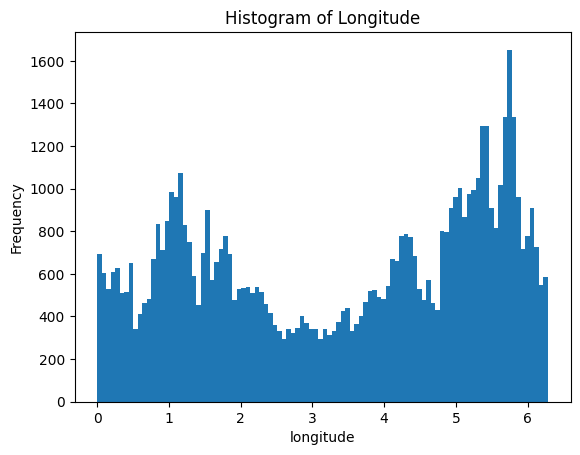

            ra        dec  parallax  parallax_error      pmra     pmdec  \
5   295.490946  25.535412  0.504844        0.036735 -2.142597 -6.938642   
9   294.792329  25.391685  0.444780        0.024213  0.698108 -1.496573   
15  237.928350 -60.203550  0.365535        0.024994 -5.579079 -5.773031   
19  240.398719 -56.193404  0.199560        0.038561 -8.259008 -6.927405   
25  268.655663 -17.721790  0.291159        0.050428 -0.678408 -4.158733   

    phot_g_mean_mag  phot_bp_mean_mag  phot_rp_mean_mag  radial_velocity  \
5         14.648816         16.081766         13.473923        15.858812   
9         13.780283         14.868395         12.749985       -15.081814   
15        13.135035         14.129029         12.156444       -70.796691   
19        13.665848         15.215737         12.449403       -84.922666   
25        13.478915         14.938174         12.289567       -28.476122   

    radial_velocity_error         l         b  
5                2.322011  1.068285  1.20040

In [6]:
import matplotlib.pyplot as plt
# select the rows that have 'b' (galactic lattitude) less than 5 and greater than -5 (degrees)

bMax = 5
df = df.loc[(df['b'] >= -bMax) & (df['b'] <= bMax)]

# we have some huge relative errors on radial velocity for radial velocity near 0, impose a limit of 20%
RadVelMaxRelError = 0.2
df = df.loc[(df['radial_velocity_error'] / np.abs(df['radial_velocity'])) <= RadVelMaxRelError]
# convert to radiant, np trigonometric functions require radiants, i'd rather convert once rather than converting every time for calculations
df['l'] = np.deg2rad(df['l'])
plt.hist(df['l'], bins=100)
plt.xlabel('longitude')
plt.ylabel('Frequency')
plt.title('Histogram of Longitude')
plt.show()
print(df.head())
df = df.reset_index(drop=True)

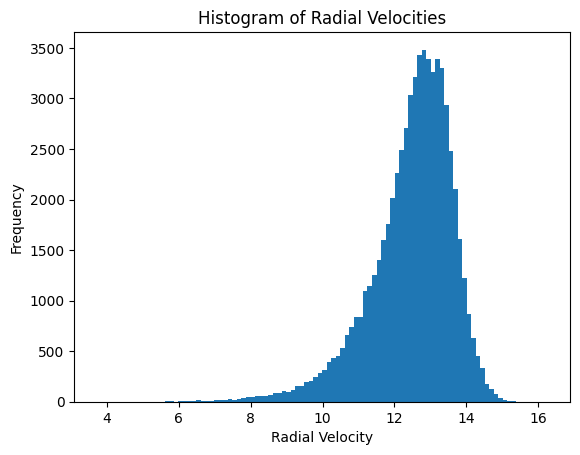

In [7]:
plt.hist(df['phot_g_mean_mag'], bins=100)
plt.xlabel('Radial Velocity')
plt.ylabel('Frequency')
plt.title('Histogram of Radial Velocities')
plt.show()

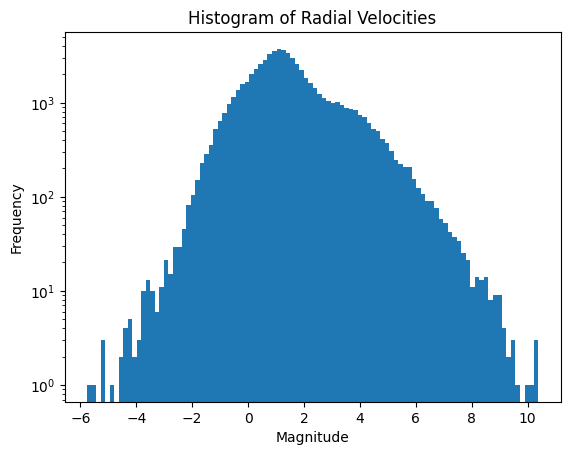

In [8]:
# Calculate distance in parsecs from parallax (milliarcseconds)
df['d'] = 1000 / df['parallax']
df['sigmad'] = 1000 * df['parallax_error'] / (df['parallax']**2)

# compute once and for all sines and cosines of l
df['cosl'] = np.cos(df['l'])
df['sinl'] = np.sin(df['l'])

# Calculate distance from center of galaxy from longitude, R and d
R = 8300
df['D'] = np.sqrt( df['d']**2 + R**2 - 2*df['d']*R*df['cosl'])

# compute sin and cos of phi
df['cosphi'] = (df['d'] * df['cosl'] - R) / df['D'] 
df['sigmacosphi'] = (df['d']*R*(df['sinl']**2) / (df['D']**3)) * df['sigmad']
df['sinphi'] = (df['d'] * df['sinl']) / df['D']
df['sigmasinphi'] = np.abs( R*df['sinl']*df['cosphi'] / (df['D']**2))*df['sigmad']

#print(df['sigmad'].head(),df['d'].head(),df['parallax'].head(),df['parallax_error'].head())

# select outside of the core
CoreRad = 1000

# plot a histogram of radial velocities with 100 bins
df['M']=df['phot_g_mean_mag']- 5*np.log10(df['d']/10)
plt.hist(df['M'], bins=100)
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram of Radial Velocities')
plt.show()

# for now, just take away circular corona, but we are dumping data
#df = df.loc[(df['d'] >= R + CoreRad) | (df['d'] <= R - CoreRad)]
#df.info()


Text(0, 0.5, 'l [rad]')

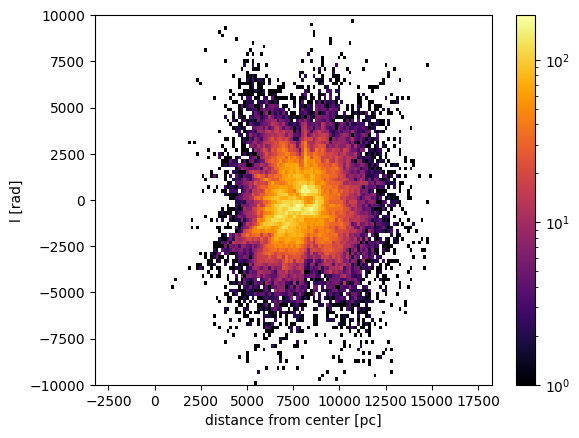

In [9]:
from matplotlib.colors import LogNorm
PhiMax = 2*np.pi

dfmag = df.loc[(df['M'] <= 4)]

plt.hist2d(-dfmag['D']*dfmag['cosphi'], dfmag['D']*dfmag['sinphi'], bins = (100, 100), norm=LogNorm(), range=((0, 15000), (-10000, 10000)), cmap = "inferno")
plt.colorbar()
plt.axis('equal')
plt.xlabel("distance from center [pc]")
plt.ylabel("l [rad]")

Text(0, 0.5, 'l [rad]')

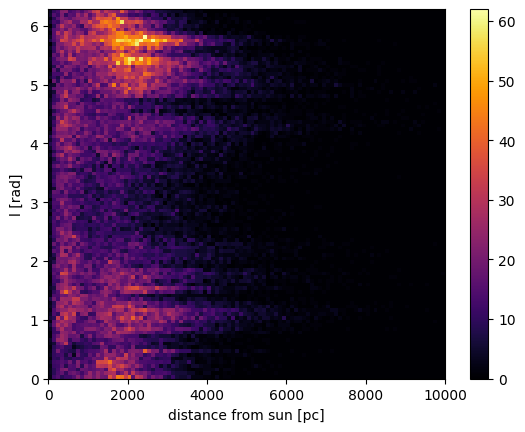

In [10]:
# where are the stars in terms of radial distance and l?

PhiMax = 2*np.pi

plt.hist2d(df['d'], df['l'], bins = (100, 100), range=((0, 10000), (0, PhiMax)), cmap = "inferno")
plt.colorbar()
plt.xlabel("distance from sun [pc]")
plt.ylabel("l [rad]")

Text(0, 0.5, 'relative error on distance [a.u.]')

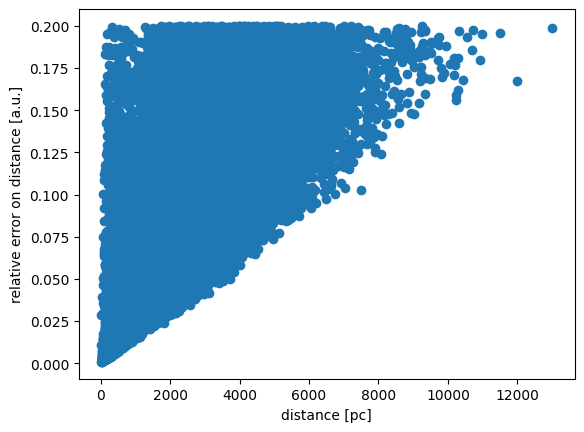

In [11]:
# how are the relative errors distributed?
# by error propagation, the relative error on the parallax is equal to that on the distance
plt.scatter(df['d'], df['parallax_error'] / df['parallax'])
plt.xlabel("distance [pc]")
plt.ylabel("relative error on distance [a.u.]")

Text(0, 0.5, 'relative error on radial velocity')

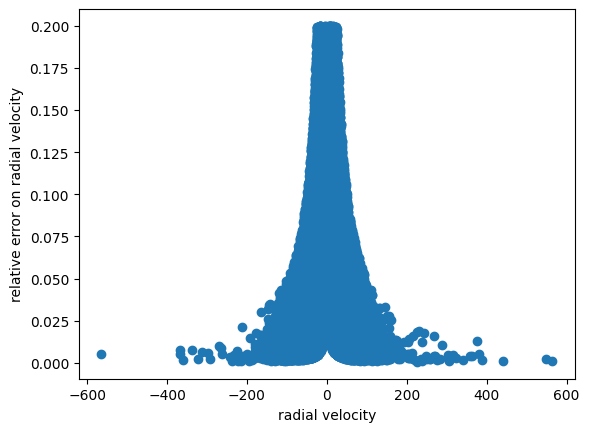

In [12]:
plt.scatter(df['radial_velocity'], df['radial_velocity_error'] / np.abs(df['radial_velocity']))
plt.xlabel('radial velocity')
plt.ylabel('relative error on radial velocity')

In [13]:
# test values to see histogram of differences
VRot_try = 200
U_try = 11.1
V_try = 12.24

df['v_rad_model'] = VRot_try * ( df['sinphi'] * df['cosl'] - (1 + df['cosphi'])*df['sinl']) - U_try*df['cosl'] - V_try * df['sinl']
df['vradDiff'] = df['radial_velocity'] - df['v_rad_model']

Text(0, 0.5, 'counts')

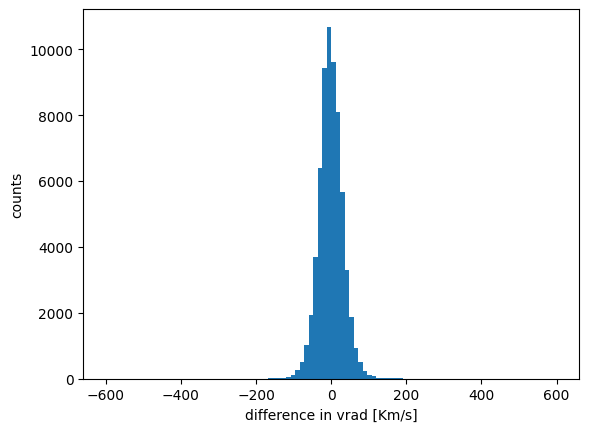

In [14]:
plt.hist(df['vradDiff'], bins = 100, range = (-600, 600))
plt.xlabel("difference in vrad [Km/s]")
plt.ylabel("counts")

Text(0, 0.5, 'difference in vrad [Km/s]')

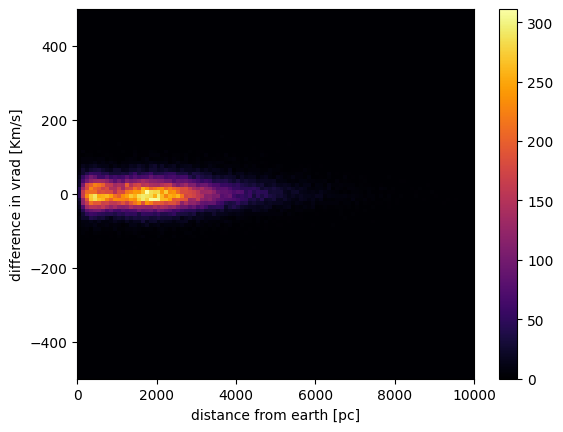

In [15]:
plt.hist2d(df['d'], df['vradDiff'], bins = (100, 100), range=((0, 10000), (-500, 500)), cmap = "inferno");
plt.colorbar()
plt.xlabel("distance from earth [pc]")
plt.ylabel("difference in vrad [Km/s]")


Text(0, 0.5, 'difference in vrad [Km/s]')

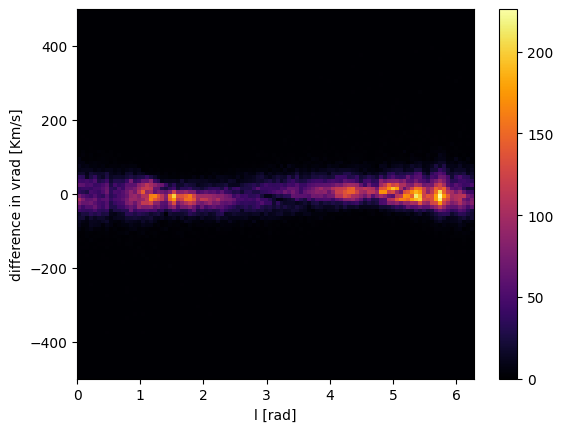

In [16]:
plt.hist2d(df['l'], df['vradDiff'], bins = (100, 100), range=((0, 2*np.pi), (-500, 500)), cmap = "inferno");
plt.colorbar()
plt.xlabel("l [rad]")
plt.ylabel("difference in vrad [Km/s]")

C:\Users\sedan\AppData\Local\Temp\ipykernel_18116\3288398337.py:14: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(xcenters, ycenters, np.log(hist.T),  cmap="inferno")
C:\Users\sedan\AppData\Local\Temp\ipykernel_18116\3288398337.py:14: RuntimeWarning: invalid value encountered in log
  plt.pcolormesh(xcenters, ycenters, np.log(hist.T),  cmap="inferno")


Text(0.5, 1.0, 'Contour plot of log(vradDiff) as a function of d and l')

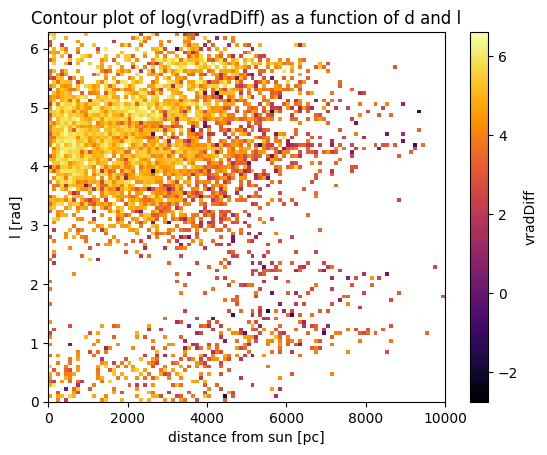

In [17]:
# Create a contour plot of vradDiff as a function of d and l
d_values = df['d']
l_values = df['l']
vrad_diff_values = df['vradDiff']

# Create a 2D histogram for contour plotting
hist, xedges, yedges = np.histogram2d(d_values, l_values, bins=(100, 100), range=((0, 10000), (0, 2 * np.pi)), weights=vrad_diff_values)

# Compute the bin centers
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2

# Create the contour plot
plt.pcolormesh(xcenters, ycenters, np.log(hist.T),  cmap="inferno")
plt.colorbar(label="vradDiff")
plt.xlabel("distance from sun [pc]")
plt.ylabel("l [rad]")
plt.title("Contour plot of log(vradDiff) as a function of d and l")


In [18]:
# variance on difference, for now, just use error on vrad, bu errors on parallax must be propagated
df['propagation'] = (df['cosl']**2)*(df['sigmasinphi']**2) + (df['sinl']**2)*(df['sigmacosphi']**2)
df['var'] = df['radial_velocity_error']**2

In [19]:
# intervals for the parameters


In [26]:
# log likelyhood 
def log_like(par,vrad,var,prop,sinl,cosl,sinphi,cosphi):
    vrot,u,v=par
    return -0.5*np.sum((vrad - vrot*( sinphi*cosl - (1 + cosphi)*sinl) - u*cosl - v*sinl)**2)/(var + (vrot**2)*prop)

#tipical star motion in galaxies
vgal=200

# log prior
def log_prior(par, vgal):
    vrot,u,v=par
    if not -500<=vrot<=500:
        return -np.inf
    return -0.5*(u**2+v**2)/vgal

# log prob
def log_prob(par,vrad,var,prop,sinl,cosl,sinphi,cosphi,vgal):
    lp=log_prior(par, vgal)
    return lp + log_like(par,vrad,var,prop,sinl,cosl,sinphi,cosphi)

In [33]:
import emcee

ndim = 3  
nwalkers = 10  
nsteps = 1000 
burnin = 300

# Valori iniziali casuali per i walker
p0 = np.random.randn(nwalkers, ndim) 

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(df['radial_velocity'], df['var'], df['propagation'], df['sinl'], df['cosl'], df['sinphi'], df['cosphi'], vgal))

sampler.run_mcmc(p0, nsteps, progress=True)

flat_samples = sampler.get_chain(discard=burnin, thin=10, flat=True)

print("Forma dei campioni:", flat_samples.shape)


Forma dei campioni: (700, 3)


Text(0.5, 0, 'step number')

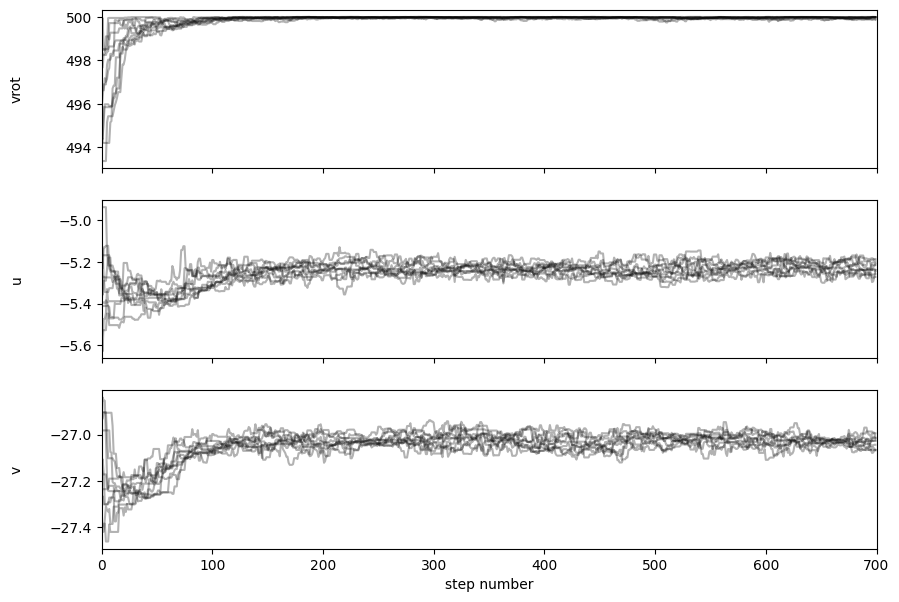

In [34]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=burnin)
labels = ["vrot", "u", "v"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

(700, 3)


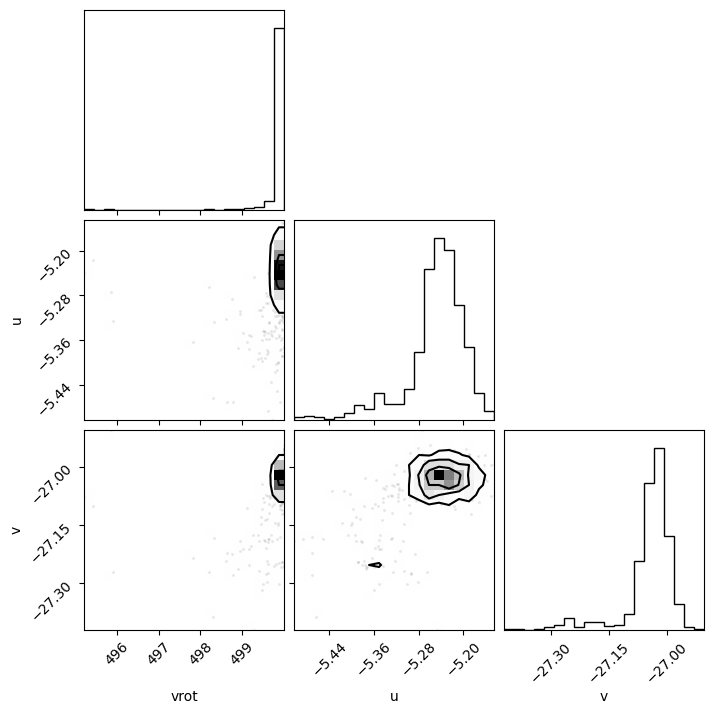

In [35]:
import corner
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=labels)